# Project : Adoption Rate Prediction

The dataset presents pet's characteristics and includes tabular, text and image data. It's come from: https://www.petfinder.my.

The aim is to predict the rate at which a pet is adopted.

**Data fields:**

* index - Unique hash ID of pet profile
* Type - Dog or Cat
* Age - Age of pet when listed, in months
* Gender - Gender of pet (Male, Female, Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet
* Color2 - Color 2 of pet 
* Color3 - Color 3 of pet 
* MaturitySize - Size at maturity (Small, Medium, Large, Extra Large, Not Specified)
* FurLength - Fur length (Short, Medium, Long, Not Specified)
* Vaccinated - Pet has been vaccinated (Yes, No, Not Sure)
* Dewormed - Pet has been dewormed (Yes, No, Not Sure)
* Sterilized - Pet has been spayed / neutered (Yes, No, Not Sure)
* Health - Health Condition (Healthy, Minor Injury, Serious Injury, Not Specified)
* Fee - Adoption fee (0 = Free)
* Breed - breed of pet (see on the dataset)
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.
* Image - a pointer to an image

The aim is to predic AdoptionSpeed. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way: 

* 0 - Pet was adopted on the same day as it was listed. 
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed. 
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed. 
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed. 
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

Submissions are scored based on the quadratic weighted kappa, which measures the agreement between two ratings. This metrics exist on sklean: sklearn.metrics.cohen_kappa_score with weights="quadratic".

# Data Loading

## load modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd     # load data
import numpy as np 
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm import tqdm
from skimage import io
import warnings
warnings.filterwarnings("ignore")

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import cv2
from imblearn.over_sampling import RandomOverSampler
from sklearn import set_config
from joblib import dump, load
from sklearn import svm
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score,cohen_kappa_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector

import gensim
from gensim.models import Word2Vec
import nltk
import string


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## load data

In [4]:
path = ("/content/drive/MyDrive/Machine_Learning_Algorithms/Project/")
TRAIN = pd.read_csv(path+"data/train.csv")
TEST = pd.read_csv(path+"data/test.csv")

# EDA

#### Number of observations for the train and the test

>This data set is Tabular data consisting of images, text, categorical columns, and numerical coulmns. The train set consists of 9000 rows and 17 columns. The test set consists of 16 columns excluding target columns and 500 rows. In this project, the target column intends to construct a multi-class classification model with AdoptionSpeed.

In [5]:
TRAIN.shape, TEST.shape

((9000, 17), (500, 16))

In [6]:
TRAIN.head()

,Type,Age,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Fee,Description,AdoptionSpeed,Images,Breed
0,Dog,84.0,Male,Brown,Cream,Unknown,Small,No,Unknown,Yes,No,Healthy,0.0,He is either lost or abandoned. Please contact...,4.0,3b178aa59-5.jpg,Terrier
1,Dog,1.0,Female,Black,Unknown,Unknown,Medium,Yes,No,Yes,No,Healthy,50.0,"Hi, my name is Rose. I'm very friendly and am ...",3.0,2fbf2cb7c-1.jpg,Mixed_Breed
2,Dog,1.0,Male,Brown,Unknown,Unknown,Medium,Yes,No,No,No,Healthy,0.0,Puppy's age is unknown. My husband went mounta...,1.0,97f683e04-1.jpg,Mixed_Breed
3,Dog,3.0,Male,Black,Unknown,Unknown,Medium,Yes,Unknown,Yes,Unknown,Healthy,0.0,"Hi, I'm Randy, few weeks ago I got beaten by h...",4.0,479500716-2.jpg,Mixed_Breed
4,Dog,8.0,Male,Brown,Unknown,Unknown,Large,Yes,Yes,Yes,No,Healthy,0.0,"Abandoned puppy looking for a home. Hi, he is ...",3.0,4a2270c3e-4.jpg,Mixed_Breed



#### Types of each feature
>

This data has types of each columns as below

| Attribute | column                                                                                                                                  | N of columns |
|:---------:|-----------------------------------------------------------------------------------------------------------------------------------------|--------------|
| Categoric | 'Type', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength',  'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Breed' | 12           |
| Numeric   | 'Age', 'Fee'                                                                                                                            | 2            |
| Text      | 'Description'                                                                                                                           | 1            |
| Image     | 'Images'                                                                                                                                | 1            |

In [7]:
TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           9000 non-null   object 
 1   Age            9000 non-null   float64
 2   Gender         9000 non-null   object 
 3   Color1         9000 non-null   object 
 4   Color2         9000 non-null   object 
 5   Color3         9000 non-null   object 
 6   MaturitySize   9000 non-null   object 
 7   FurLength      9000 non-null   object 
 8   Vaccinated     9000 non-null   object 
 9   Dewormed       9000 non-null   object 
 10  Sterilized     9000 non-null   object 
 11  Health         9000 non-null   object 
 12  Fee            9000 non-null   float64
 13  Description    9000 non-null   object 
 14  AdoptionSpeed  9000 non-null   float64
 15  Images         9000 non-null   object 
 16  Breed          9000 non-null   object 
dtypes: float64(3), object(14)
memory usage: 1.2+ MB


In [8]:
TRAIN['Description'][0]

'He is either lost or abandoned. Please contact us if you know his owner...'

In [9]:
TRAIN['Images'][0]

'3b178aa59-5.jpg'

To load image, I assign the path where the image is stored in the image column.

In [10]:
img_dir_train = "data/train/"
img_dir_test = "data/test/"
TRAIN['Images'] = [path+img_dir_train+img for img in TRAIN['Images']]
TEST['Images'] = [path+img_dir_test+img for img in TEST['Images']]

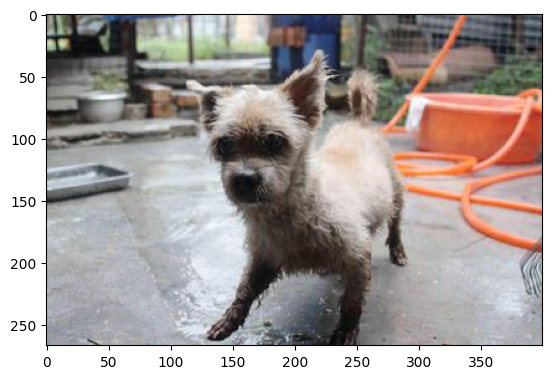

In [11]:
# Read the first image of the list
img = io.imread(TRAIN['Images'][0])
# have a look to the image
plt.imshow(img)

Here, I stored column names in each variable to preprocess differently for each type of column.

In [12]:
cat_cols = ['Type', 'Gender',  'Color1', 'Color2', 'Color3',
            'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health','Breed']
num_cols = ['Age', 'Fee']
txt_cols = ['Description']
img_cols = ['Images']

target = "AdoptionSpeed"


#### Number of observations per class

0.0     247
1.0    1894
2.0    2504
3.0    2061
4.0    2294
Name: AdoptionSpeed, dtype: int64


Text(0.5, 1.0, 'Adoption speed classes counts')

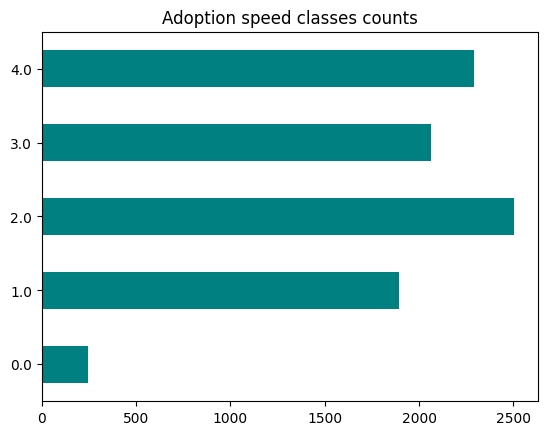

In [13]:
TRAIN[target].value_counts().sort_index().plot(kind='barh', color='teal')
print(TRAIN[target].value_counts().sort_index())
plt.title('Adoption speed classes counts') # lack of 0.0 data

This data is imbalanced especially on class 0. When training a model on imbalanced data, the model tends to favor the majority class, leading to poor performance on the minority class. So in this learning, sampling stratagy is needed to create a balanced training set that will allow the model to learn from both classes equally and reduce the bias towards the majority class.

In my project, I tested the strategy by 3 ways.


1. Increase the data by RandomOverSampler(ROS) 
2. Increase the data by SMOTE
3. Use class_weight parameter of the model.

In my first trial, the third stratagy had better performance in RandomforestClassifier, but I used the first stratagy to fine tune since class_weight parameter was not in other classifier models but I wanted to gridsearch to compare models with sampling. So, I added the RandomoverSampler in pipeline.

# Preprocess

## Missing value

First of all, I checked the missing value. But in this dataset, the missing value is not exist. 

In [14]:
TRAIN.isnull().sum()

Type             0
Age              0
Gender           0
Color1           0
Color2           0
Color3           0
MaturitySize     0
FurLength        0
Vaccinated       0
Dewormed         0
Sterilized       0
Health           0
Fee              0
Description      0
AdoptionSpeed    0
Images           0
Breed            0
dtype: int64

However, this data contains many unknown values in categorical data. Check whether this unknown value is a missing value.

In [15]:
# Count and print 'Unknown' values in each column
for column in TRAIN.columns:
    try:
        unknown_count = TRAIN[column].value_counts()['Unknown']
        print(f"'Unknown' count in {column}: {unknown_count}")
    except KeyError:
        print(f"'Unknown' does not exist in {column}")

'Unknown' does not exist in Type
'Unknown' does not exist in Age
'Unknown' does not exist in Gender
'Unknown' does not exist in Color1
'Unknown' count in Color2: 3078
'Unknown' count in Color3: 7055
'Unknown' does not exist in MaturitySize
'Unknown' count in FurLength: 578
'Unknown' count in Vaccinated: 1125
'Unknown' count in Dewormed: 1048
'Unknown' count in Sterilized: 967
'Unknown' does not exist in Health
'Unknown' does not exist in Fee
'Unknown' does not exist in Description
'Unknown' does not exist in AdoptionSpeed
'Unknown' does not exist in Images
'Unknown' count in Breed: 2


According the description of the each column, I don't treat 'Unkown' value to Missing value. And, I consider it as a value.

## Preprocessing numeric columns

### Distribution and Outlier

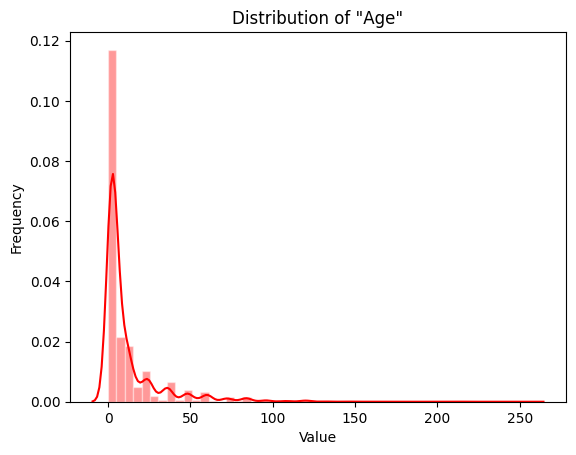

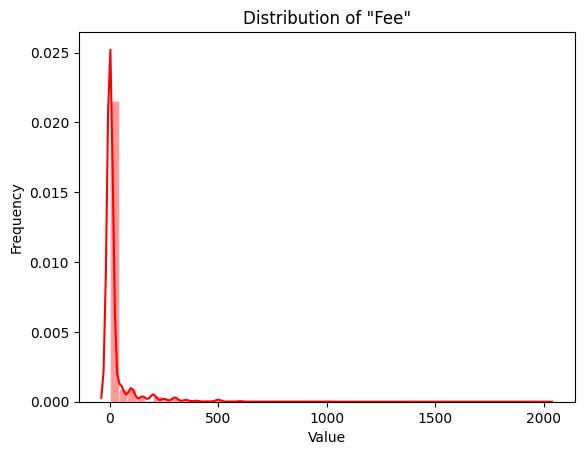

In [16]:
for column in TRAIN[num_cols].columns:
    # Create a histogram of the column's distribution

    sns.distplot(a=TRAIN[column], color='red',
             hist_kws={"edgecolor": 'white'})
    
    plt.title(f'Distribution of "{column}"')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

Since the numerical columns of this data set are not distributed well, normalization is required during training. I will make a pipeline to normalize the data before building model.

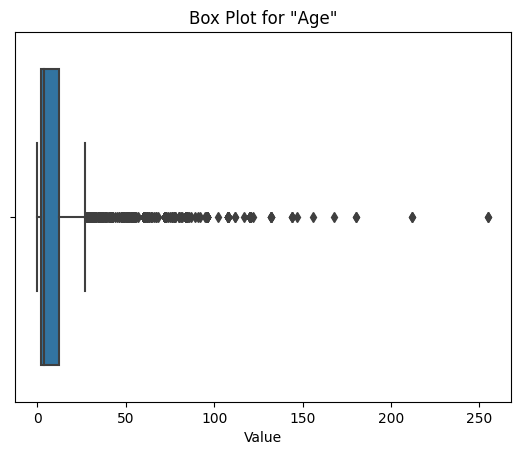

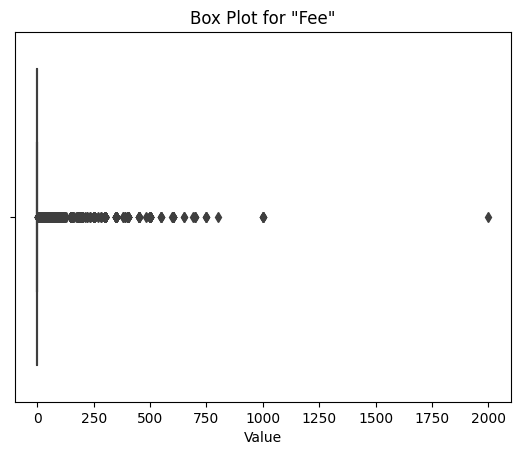

In [17]:
for column in TRAIN[num_cols]:
    
    # Create the box plot
    sns.boxplot(x=TRAIN[column])
    
    # Set the title and labels for the plot
    plt.title(f'Box Plot for "{column}"')
    plt.xlabel('Value')
    
    # Show the plot
    plt.show()

In [18]:
# Define a function to count the number of outliers in a column
def count_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    upper_whisker = q3 + 1.5 * iqr
    lower_whisker = q1 - 1.5 * iqr
    outliers = column[(column > upper_whisker) | (column < lower_whisker)]
    return len(outliers)

# Loop through each column in the DataFrame
for column in TRAIN[num_cols]:
    outliers = count_outliers(TRAIN[column])
    print(f'Number of outliers in "{column}": {outliers}')


Number of outliers in "Age": 1057
Number of outliers in "Fee": 1545


By Interquartile Range (IQR) method, I found over 1000 data is outlier. And it was too large to remove all, even I wasn't sure column "Age" and "Fee" are greatly contributed to model. So, I just kept it and compared the result to treat it.

In addition, I also checked, if there are values more than common sense(e.g. The average life of dog is from 10 to 15 years/dog adoption costs can range from 50 to 500 dollors in normal)

In [19]:
print("Number of the pet is over 15 years old: ",len(TRAIN[TRAIN['Age'] >= 180])) #print pets over 15 years old. and it is 6. it'll be better to remove to improve performance
print("Number of the pet has adoption fee over $1000: ",len(TRAIN[TRAIN['Fee'] >= 1000])) #print pets has over 1000 as adoption fee. and it is 5. it'll be better to remove to improve performance

Number of the pet is over 15 years old:  6
Number of the pet has adoption fee over $1000:  5


11 over 9000 data were founded as outlier.

I initially removed these 11 outliers and proceeded with the modeling. But by removing these outliers, the accuracy decreased unexpectedly. Therefore, without removing outliers in this preprocess stage, I would like to compare the results of StandardScaler and RobustScaler which are less sensitive to outliers, when tuning parameters afterwards, and use ideal scaler for modeling.

## Preprocessing images

### Compute ORB detector and descriptors for one image

In machine learning models, it's often useful to extract features from the input images to represent them in a more compact and discriminative way. These features can then be used as input to a machine learning algorithm to perform tasks such as classification or regression. 

There are several descriptors for it like SIFT, SURF. At the first trial, I used SIFT, known as a descriptor with good performance. But it takes too much time to use. The operation is slow because feature vectors of sizes 128 are used for each feature vectors.

So I tried to adapt the other descrioptor for this project, after I study the principal of the descriptor. And I found ORB descriptor. This descriptor uses FAST as a feature point detection algorithm, has been improved to consider rotation and direction, and is also used as a good alternative to SIFT and SURF due to its fast speed. 

Even when I compare the performance between the descriptors, it has also good performance with comparing SIFT with decreasing time dramatically. (Size of feature vectors is 32 of ORB descriptor) (Reference: https://ieeexplore.ieee.org/document/8346440)

(480, 32)


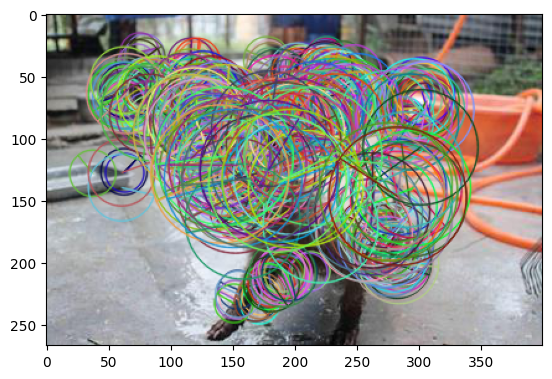

In [20]:
img = io.imread(TRAIN['Images'][0])
# convert the image to grey levels
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Make ORB detector 
orb = cv2.ORB_create()
# compute ORB detector and descriptors
kp,des = orb.detectAndCompute(gray, None)
print(des.shape)
# plot image and descriptors
cv2.drawKeypoints(img,kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

### Extract features and build BOFs

In [21]:
# First step, extract the ORBs of each image
# Here I used ORB method not SIFT.
def extract_ORB(img_lst):
    nbORBs = 0    # Number of ORBs
    ORBs = []     # List of ORBs descriptors 

    for pathImg in tqdm(img_lst, position=0, leave=True): 
        img = io.imread(pathImg)
        if img.shape[0] <=100 or img.shape[1] <=100:
            img = cv2.resize(img, (img.shape[1]*5, img.shape[0]*5)) #Resize low resolution picture quality
        if len(img.shape)==2: # this is a grey level image
            gray = img
        else: # we expect the image to be a RGB image or RGBA
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        orb = cv2.ORB_create()
        kp, des = orb.detectAndCompute(gray, None)

        nbORBs += des.shape[0]
        ORBs.append(des)
        
    return nbORBs, ORBs

In [22]:
# Step 2: clusterize the ORB
def clusterize(ORBs, nb_img_features=5, verbose=False):
    clusterizer = MiniBatchKMeans(n_clusters=nb_img_features)   # nb_img_features is a hyperparameter
    # learning of the clustering
    flat_list = ORBs[0]
    for des in ORBs[1:]:
        flat_list = np.concatenate((flat_list, des))
        if verbose:
            print("shape:", des.shape, flat_list.shape)
    clusterizer.fit(flat_list)
    # we now know the label of each ORB descriptor
    return clusterizer

In [23]:
# Step 3: build the BOW representation of each images (i.e. construction of the BOFs)
def build_BOFs(ORBs, clusterizer, verbose=False):
    ok, nok = 0, 0
    #BOF initialization
    nb_img_features = clusterizer.get_params()['n_clusters']
    BOFs = np.empty(shape=(0, nb_img_features), dtype=int)

    # Build label list
    flat_list = ORBs[0]
    for des in ORBs[1:]:
        flat_list = np.concatenate((flat_list, des))
        if verbose:
            print("shape:", des.shape, flat_list.shape)
    labels = clusterizer.predict(flat_list)

    # loop on images
    i = 0 # index for the loop on ORBs
    for des in ORBs:
        #initialisation of the bof for the current image
        tmpBof = np.array([0]*nb_img_features)
        j = 0
        # for every ORB of the current image:
        nbs = des.shape[0]
        while j < nbs:
            tmpBof[labels[i]] += 1
            j+=1
            i+=1
        BOFs = np.concatenate((BOFs, tmpBof.reshape(1,-1)), axis=0)
    if verbose:
        print("BOFs : ", BOFs)
    
    return BOFs

In [24]:
# Define the custom function to utilize it as pipeline
def list_comparaison(l1, l2):
    if not l1 is None \
        and not l2 is None \
        and len(l1)==len(l2) \
        and len(l1)==sum([1 for i,j in zip(l1, l2) if i==j]):
        return True
    return False
    
class BOF_extractor(BaseEstimator,TransformerMixin): 
    X = None
    ORBs = None
    nbORBs = 0
    
    def __init__(self, nb_img_features=5, verbose=False):
        self.nb_img_features = nb_img_features
        self.verbose = verbose
        self.path = path
        if self.verbose:
            print("BOF.init()")
        
    def fit(self, X, y=None):
        if self.verbose:
            print("BOF.fit()")
        if list_comparaison(X, self.X):
            ORBs = self.ORBs 
            nbORBs = self.nbORBs
        else:
            if self.verbose:
                print("extract_ORB")
            nbORBs, ORBs = extract_ORB(X)
        self.X = X
        self.ORBs = ORBs 
        self.nbORBs = nbORBs
        self.clusterizer = clusterize(ORBs, self.nb_img_features, self.verbose)
        
    def transform(self, X, y=None):
        if self.verbose:
            print("BOF.transform()")
        if list_comparaison(X, self.X):
            ORBs = self.ORBs 
            nbORBs = self.nbORBs
        else:
            if self.verbose:
                print("extract_ORB")
            nbORBs, ORBs = extract_ORB(X)

        if self.verbose:
            print("nbORBs:", nbORBs)
        return build_BOFs(ORBs, self.clusterizer, self.verbose)
    
    def fit_transform(self, X, y=None):
        if self.verbose:
            print("BOF.fit_transform()")
        if list_comparaison(X, self.X):
            ORBs = self.ORBs 
            nbORBs = self.nbORBs
        else:
            if self.verbose:
                print("extract_ORB")
            nbORBs, ORBs = extract_ORB(X)
        self.X = X
        self.ORBs = ORBs 
        self.nbORBs = nbORBs
        self.clusterizer = clusterize(ORBs, self.nb_img_features, self.verbose)
        return build_BOFs(ORBs, self.clusterizer, self.verbose)


## Preprocessing text

In text pre-processing, vectorization using count-based word representation and vectorization using word embedding are performed, and the results are compared.

TfidfVectorizer is one of count based word representation, which uses word frequency and inverse document frequency to represent words as vectors. Although this method is simple and effective, it has a limitation in that it cannot reflect information related to the context of words. 

On the other hand, word2vec, one of the word embeddings, expresses a word as a vector using the context of the word. Through this, the similarity between words can be calculated, and the description can be expressed as a vector using this.

The embedding method using word2vec can give more accurate results than TfidfVectorizer. However, when using word2vec, the embeddings may not be trained sufficiently if the dataset is small or the number of documents is small. Also, the disadvantage of using word2vec is that it takes a lot of time to train the model.

Therefore, for text preprocessing, I will compare the performance of three cases as follows, and use the method with the best performance.
* case 1) vectorizing by using simple TfidfVectorizer
* case 2) word embedding by using word2vec
* case 3) TfidfVectorizer + word2vec

### case1) vectorizing by simple TfidfVectorizer


In [25]:
# make pipeline
word_vectorizer1 = Pipeline([
    ('vectorizing', TfidfVectorizer())
])


### case2) word embedding by word2vec

In [26]:
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=5, workers=4, sg=1):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.sg = sg
    
    def fit(self, X, y=None):
        documents = [doc.split() for doc in X]
        self.word2vec_model = Word2Vec(sentences=documents, vector_size=self.vector_size, window=self.window,
                                       min_count=self.min_count, workers=self.workers, sg=self.sg)
        return self
    
    def transform(self, X, y=None):
        self.fit(X)
        documents = [doc.split() for doc in X]
        doc_vectors = np.zeros((len(documents), self.vector_size))
        for i, doc in enumerate(documents):
            vectors = []
            for word in doc:
                if word in self.word2vec_model.wv:
                    vectors.append(self.word2vec_model.wv[word])
            if len(vectors) > 0:
                doc_vectors[i] = np.mean(vectors, axis=0)
        return doc_vectors


In [27]:
# make pipeline
word_vectorizer2 = Pipeline([
    ("word embedding", Word2VecVectorizer())
    ])


In [28]:
# test = word_vectorizer2.fit_transform(X_train['Description'])
# test

### case3) word2vec + TfidfVectorizer

In [29]:
# make pipeline
word_vectorizer3 = Pipeline([
    ("word embedding", Word2VecVectorizer(),
    ('vectorizing', TfidfVectorizer()))
    ])


# Data split and sampling

Due to the imbalance of the classes we looked at earlier, I adjusted the classes to be balanced by using the sampler before learning. In the case of SMOTE, the running time is longer than that of ROS, so in this modeling, parameter tuning was performed based on the ROS sampler.

In [30]:
# define function to use in pipeline.
class RandomOverSamplerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_strategy='auto'):
        self.sampling_strategy = sampling_strategy
        self.ros = RandomOverSampler(sampling_strategy=self.sampling_strategy)

    def fit(self, X, y):
        X_resampled, y_resampled = self.ros.fit_resample(X, y)
        return self

    def transform(self, X, y=None):
        return X

In my modeling, 1000 data in Train were divided into validation data set and used for performance comparison by model.

In [31]:
N = 8000
train = TRAIN[:N]
valid = TRAIN[N:]

X_train = train.drop([target], axis=1)
y_train = train[target]
X_val = valid.drop([target], axis=1)
y_val = valid[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((8000, 16), (8000,), (1000, 16), (1000,))

# Build a baseline


In the first modeling, I tried to prepare a baseline for parameter tuning by implementing a simple SVM classifier.

After the preprocess stage, I added dimension reduction stage. Since the features are rather complex with 15566 features, the running time was long, and the performance is somewhat degraded due to overfitting. Therefore, in the baseline, the number of features is reduced to 100, and then in parameter tuning, the value is adjusted to find the optimal number of features.

In [32]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse=False)
numerical_preprocessor = StandardScaler()
text_preprocessor = word_vectorizer1 # TfidfVectorizer()
image_preprocessor = BOF_extractor(nb_img_features=5, verbose=False)

preprocessor = ColumnTransformer(transformers=[
    ("categorical encoding", categorical_preprocessor, cat_cols),
    ("numerical encoding", numerical_preprocessor, num_cols),
    ("text encoding", text_preprocessor, 'Description'),
    ("image encoding", image_preprocessor, 'Images')

])

dim_red = FeatureUnion([("Truncated SVD", TruncatedSVD(n_components=100))])

model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("dimensionality reduction", dim_red),
    ("resampling", RandomOverSamplerTransformer(sampling_strategy='auto')),
    ("classifying", svm.SVC()),
])

model.fit(X_train,y_train)

'categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse=False)\nnumerical_preprocessor = StandardScaler()\ntext_preprocessor = word_vectorizer1 # TfidfVectorizer()\nimage_preprocessor = BOF_extractor(nb_img_features=5, verbose=False)\n\npreprocessor = ColumnTransformer(transformers=[\n    ("categorical encoding", categorical_preprocessor, cat_cols),\n    ("numerical encoding", numerical_preprocessor, num_cols),\n    ("text encoding", text_preprocessor, \'Description\'),\n    ("image encoding", image_preprocessor, \'Images\')\n\n])\n\ndim_red = FeatureUnion([("Truncated SVD", TruncatedSVD(n_components=100))])\n\nmodel = Pipeline(steps=[\n    ("preprocessing", preprocessor),\n    ("dimensionality reduction", dim_red),\n    ("resampling", RandomOverSamplerTransformer(sampling_strategy=\'auto\')),\n    ("classifying", svm.SVC()),\n])\n\nmodel.fit(X_train,y_train)\n\nset_config(display="diagram")\nmodel'

In [77]:
set_config(display="text")

In [78]:
# Save the model
#dump(model, '/content/drive/MyDrive/Machine_Learning_Algorithms/Project/Hyelim_base.pkl')
#model =load('/content/drive/MyDrive/Machine_Learning_Algorithms/Project/Hyelim_base.pkl')
model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical encoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Type', 'Gender', 'Color1',
                                                   'Color2', 'Color3',
                                                   'MaturitySize', 'FurLength',
                                                   'Vaccinated', 'Dewormed',
                                                   'Sterilized', 'Health',
                                                   'Breed']),
                                                 ('numerical encoding',
                                                  StandardScaler(),
                                                  ['Age', 'Fee']),
                                                 ('text encoding',
      

In [34]:
# Print the result about train set
y_pred_tb = model.predict(X_train)
print("ACC on train", accuracy_score(y_train, y_pred_tb))
print("Cohen_kappa_score on train", cohen_kappa_score(y_train, y_pred_tb, weights= 'quadratic')) 

ACC on train 0.284
Cohen_kappa_score on train 0.036804244232695016


In [35]:
# Print the result about validation set
y_pred_vb = model.predict(X_val)
print("ACC on valid", accuracy_score(y_val, y_pred_vb))
print("Cohen_kappa_score on valid", cohen_kappa_score(y_val, y_pred_vb, weights= 'quadratic')) 

100%|██████████| 1000/1000 [04:16<00:00,  3.90it/s]


ACC on valid 0.28
Cohen_kappa_score on valid 0.03450473842577417


In [36]:
### Save my base predictions
print("Test size:", len(TEST))
y_pred_b = model.predict(TEST)

Test size: 500


100%|██████████| 500/500 [01:49<00:00,  4.56it/s]


# Fine tune

In the fine tune step, grid search was performed for each step to find the optimal model and parameters as below.

* Step 1) Select baseline model
* Step 2) Select preprocessor of text with the selected model
* Step 3) Hyper parameter tunning of the model
* Step 4) Hyper parameter tunning of the preprocessing parameter


### Step 1) Select base line model

In step1, I tried to find a base classifier to improve in further step. And, I proceede gridsearch with 3 models I learned in the last classes - RandomforestClassifier, KNN Classifier, AdaBoost Classifier.


Note) About Naive Bayse models, I tried to utilize it to gridsearch with these models, but it was hard to set the pipeline for categorical and numerical columns saperately for NB(to use MultinomialNB and GaussianNB to different types) with these. So, here I just remained 3 models to compare.

In [37]:
'''# Define the preprocessor pipeline
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse=False)
numerical_preprocessor = StandardScaler()
text_preprocessor = word_vectorizer1 # TfidfVectorizer()
image_preprocessor = BOF_extractor()

preprocessor = ColumnTransformer(transformers=[
    ("categorical encoding", categorical_preprocessor, cat_cols),
    ("numerical encoding", numerical_preprocessor, num_cols),
    ("text encoding", text_preprocessor, 'Description'),
    ("image encoding", image_preprocessor, 'Images')

])

dim_red = FeatureUnion([("Truncated SVD", TruncatedSVD(n_components=100))])

model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("dimensionality reduction", dim_red),
    ("resampling", RandomOverSamplerTransformer(sampling_strategy='auto')),
    ("classifying", RandomForestClassifier()),
])
    
# Define the hyperparameter grid for the random forest model
param_grid = {
    'classifying': [RandomForestClassifier(), KNeighborsClassifier(), AdaBoostClassifier()]

}

# Define the grid search object
grid_search = GridSearchCV(
    model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy',return_train_score=True
)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Get the best estimator from the grid search
best_estimator = grid_search.best_estimator_



# Print the best hyperparameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)'''

'# Define the preprocessor pipeline\ncategorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse=False)\nnumerical_preprocessor = StandardScaler()\ntext_preprocessor = word_vectorizer1 # TfidfVectorizer()\nimage_preprocessor = BOF_extractor()\n\npreprocessor = ColumnTransformer(transformers=[\n    ("categorical encoding", categorical_preprocessor, cat_cols),\n    ("numerical encoding", numerical_preprocessor, num_cols),\n    ("text encoding", text_preprocessor, \'Description\'),\n    ("image encoding", image_preprocessor, \'Images\')\n\n])\n\ndim_red = FeatureUnion([("Truncated SVD", TruncatedSVD(n_components=100))])\n\nmodel = Pipeline(steps=[\n    ("preprocessing", preprocessor),\n    ("dimensionality reduction", dim_red),\n    ("resampling", RandomOverSamplerTransformer(sampling_strategy=\'auto\')),\n    ("classifying", RandomForestClassifier()),\n])\n    \n# Define the hyperparameter grid for the random forest model\nparam_grid = {\n    \'classifying\': [RandomForestCl

In [ ]:
# Define the preprocessor pipeline
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse=False)
numerical_preprocessor = StandardScaler()
text_preprocessor = word_vectorizer1 # TfidfVectorizer()
image_preprocessor = BOF_extractor()

preprocessor = ColumnTransformer(transformers=[
    ("categorical encoding", categorical_preprocessor, cat_cols),
    ("numerical encoding", numerical_preprocessor, num_cols),
    ("text encoding", text_preprocessor, 'Description'),
    ("image encoding", image_preprocessor, 'Images')

])

dim_red = FeatureUnion([("Truncated SVD", TruncatedSVD(n_components=100))])

best_estimator = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("dimensionality reduction", dim_red),
    ("resampling", RandomOverSamplerTransformer(sampling_strategy='auto')),
    ("classifying", RandomForestClassifier()),
])

# Fit the grid search object to the training data
best_estimator.fit(X_train, y_train)


In [79]:
# Save the model
#dump(best_estimator, '/content/drive/MyDrive/Machine_Learning_Algorithms/Project/Hyelim_final_grid1.pkl')
#Best parameters: {'classifying': RandomForestClassifier()}
#best_estimator =load('/content/drive/MyDrive/Machine_Learning_Algorithms/Project/Hyelim_final_grid1.pkl')
best_estimator

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical encoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Type', 'Gender', 'Color1',
                                                   'Color2', 'Color3',
                                                   'MaturitySize', 'FurLength',
                                                   'Vaccinated', 'Dewormed',
                                                   'Sterilized', 'Health',
                                                   'Breed']),
                                                 ('numerical encoding',
                                                  StandardScaler(),
                                                  ['Age', 'Fee']),
                                                 ('text encoding',
      

In [39]:
#model = load('Hyelim.joblib') 
y_pred_t1 = best_estimator.predict(X_train)
print("ACC on train", accuracy_score(y_train, y_pred_t1)) 
print("Cohen_kappa_score on train", cohen_kappa_score(y_train, y_pred_t1, weights= 'quadratic')) 

ACC on train 0.999875
Cohen_kappa_score on train 0.9999533940709568


In [40]:
y_pred_v1 = best_estimator.predict(X_val)
print("ACC on valid", accuracy_score(y_val, y_pred_v1)) 
print("Cohen_kappa_score on valid", cohen_kappa_score(y_val, y_pred_v1, weights= 'quadratic')) 

100%|██████████| 1000/1000 [00:16<00:00, 61.42it/s]


ACC on valid 0.384
Cohen_kappa_score on valid 0.3353390845178522


In [41]:
### Save my base predictions
print("Test size:", len(TEST))
y_pred_1 = best_estimator.predict(TEST)
# Save your predictions
df_results1 = pd.DataFrame(data={'final_grid1':y_pred_1})
df_results1.to_csv("/content/drive/MyDrive/Machine_Learning_Algorithms/Project/save/results_final_grid1.csv")

Test size: 500


100%|██████████| 500/500 [00:08<00:00, 58.89it/s]


Comparing three algorithm, RandomForestClassifier had the best performance. So, I will use randomforestclassifier as my base model and I will conduct hyperparameter tunning with it.

### Step 2) Select preprocessor of text with the selected model.


In step2, I tried to compare the performance between methods to preprocess text as I mentioned above.

* case 1) vectorizing by using simple TfidfVectorizer
* case 2) word embedding by using word2vec
* case 3) TfidfVectorizer + word2vec

In [42]:
'''# Define the preprocessor pipeline
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse=False)
numerical_preprocessor = StandardScaler()
#text_preprocessor = word_vectorizer1 # TfidfVectorizer()
image_preprocessor = BOF_extractor()

preprocessor = ColumnTransformer(transformers=[
    ("categorical encoding", categorical_preprocessor, cat_cols),
    ("numerical encoding", numerical_preprocessor, num_cols),
    ("text encoding", text_preprocessor, 'Description'),
    ("image encoding", image_preprocessor, 'Images')

])

dim_red = FeatureUnion([("Truncated SVD", TruncatedSVD(n_components=100))])

model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("dimensionality reduction", dim_red),
    ("resampling", RandomOverSamplerTransformer(sampling_strategy='auto')),
    ("classifying", RandomForestClassifier()), 
])
    
# Define the hyperparameter grid for the random forest model
param_grid = {
    'preprocessing__text encoding': [word_vectorizer1, word_vectorizer2, word_vectorizer3]

}

# Define the grid search object
grid_search2 = GridSearchCV(
    model, param_grid=param_grid, cv=2, n_jobs=-1, verbose=1, scoring='accuracy',return_train_score=True
)

# Fit the grid search object to the training data
grid_search2.fit(X_train, y_train)

# Get the best estimator from the grid search
best_estimator2 = grid_search2.best_estimator_


# Print the best hyperparameters and score
print("Best parameters:", grid_search2.best_params_)
print("Best score:", grid_search2.best_score_)'''

'# Define the preprocessor pipeline\ncategorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse=False)\nnumerical_preprocessor = StandardScaler()\n#text_preprocessor = word_vectorizer1 # TfidfVectorizer()\nimage_preprocessor = BOF_extractor()\n\npreprocessor = ColumnTransformer(transformers=[\n    ("categorical encoding", categorical_preprocessor, cat_cols),\n    ("numerical encoding", numerical_preprocessor, num_cols),\n    ("text encoding", text_preprocessor, \'Description\'),\n    ("image encoding", image_preprocessor, \'Images\')\n\n])\n\ndim_red = FeatureUnion([("Truncated SVD", TruncatedSVD(n_components=100))])\n\nmodel = Pipeline(steps=[\n    ("preprocessing", preprocessor),\n    ("dimensionality reduction", dim_red),\n    ("resampling", RandomOverSamplerTransformer(sampling_strategy=\'auto\')),\n    ("classifying", RandomForestClassifier()), \n])\n    \n# Define the hyperparameter grid for the random forest model\nparam_grid = {\n    \'preprocessing__text encoding

In [ ]:
# Define the preprocessor pipeline
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse=False)
numerical_preprocessor = StandardScaler()
text_preprocessor = word_vectorizer1 # TfidfVectorizer()
image_preprocessor = BOF_extractor()

preprocessor = ColumnTransformer(transformers=[
    ("categorical encoding", categorical_preprocessor, cat_cols),
    ("numerical encoding", numerical_preprocessor, num_cols),
    ("text encoding", text_preprocessor, 'Description'),
    ("image encoding", image_preprocessor, 'Images')

])

dim_red = FeatureUnion([("Truncated SVD", TruncatedSVD(n_components=100))])

best_estimator2 = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("dimensionality reduction", dim_red),
    ("resampling", RandomOverSamplerTransformer(sampling_strategy='auto')),
    ("classifying", RandomForestClassifier()), 
])
    

# Fit the grid search object to the training data
best_estimator2.fit(X_train, y_train)

In [80]:
# Save the model
#dump(best_estimator2, '/content/drive/MyDrive/Machine_Learning_Algorithms/Project/Hyelim_final_grid2.pkl')
#Best parameters: {'preprocessing__text encoding': Pipeline(steps=[('vectorizing', TfidfVectorizer())])}
#best_estimator2 =load('/content/drive/MyDrive/Machine_Learning_Algorithms/Project/Hyelim_final_grid2.pkl')
best_estimator2

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical encoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Type', 'Gender', 'Color1',
                                                   'Color2', 'Color3',
                                                   'MaturitySize', 'FurLength',
                                                   'Vaccinated', 'Dewormed',
                                                   'Sterilized', 'Health',
                                                   'Breed']),
                                                 ('numerical encoding',
                                                  StandardScaler(),
                                                  ['Age', 'Fee']),
                                                 ('text encoding',
      

In [44]:
#model = load('Hyelim.joblib') 
y_pred_t2 = best_estimator2.predict(X_train)
print("ACC on train", accuracy_score(y_train, y_pred_t2)) 
print("Cohen_kappa_score on train", cohen_kappa_score(y_train, y_pred_t2, weights= 'quadratic')) 

ACC on train 0.999875
Cohen_kappa_score on train 0.9999533940709568


In [45]:
y_pred_v2 = best_estimator2.predict(X_val)
print("ACC on valid", accuracy_score(y_val, y_pred_v2)) 
print("Cohen_kappa_score on valid", cohen_kappa_score(y_val, y_pred_v2, weights= 'quadratic')) 

100%|██████████| 1000/1000 [00:16<00:00, 60.23it/s]


ACC on valid 0.367
Cohen_kappa_score on valid 0.32859569197564553


In [46]:
### Save my base predictions
print("Test size:", len(TEST))
y_pred_2 = best_estimator2.predict(TEST)
# Save your predictions
df_results2 = pd.DataFrame(data={'final_grid2':y_pred_2})
df_results2.to_csv("/content/drive/MyDrive/Machine_Learning_Algorithms/Project/save/results_final_grid2.csv")

Test size: 500


100%|██████████| 500/500 [00:09<00:00, 54.10it/s]


Unlike the expectation that case 2 or case 3 using word embedding would have good performance, simple TfidfVectorizer showed the best performance. After referring several experiments on performance comparison of word embedding and TfidfVectorizer, (1) https://beei.org/index.php/EEI/article/view/3157/2341, 2)https://www.kaggle.com/code/rockystats/bbc-text-classification-word2vec-vs-tf-idf) the following reasons could be considered.

1. Data size: The size of the training data could be one of the factors contributing to the better performance of TfidfVectorizer. Word2Vec embeddings generally require large amounts of data to generate meaningful representations, and if the dataset used for training the Word2VecVectorizer is relatively small, the resulting embeddings may not be very informative. On the other hand, TfidfVectorizer may perform better on small datasets since it can capture the importance of each word in a document based on its frequency in the document and across the corpus.

2. Hyperparameter tuning: It's possible that the hyperparameters of the Word2VecVectorizer were not tuned properly for the given dataset. The performance of Word2Vec embeddings can be sensitive to the choice of hyperparameters such as the vector size, window size, and min_count. If the hyperparameters are not optimized for the dataset, the resulting embeddings may not be as effective in capturing the relevant information in the text.

3. Classification task: It's possible that the TfidfVectorizer is more effective than Word2Vec embeddings in capturing the important features for the specific task being performed. For example, if the classification task involves detecting the presence of specific keywords or phrases in the text, then TfidfVectorizer may be more effective.

4. Pre-processing of text: In my pipeline, sufficient cleaning and normalization of text were not done before fitting the word-embedding model. After cleaning the text, it is necessary to compare the corresponding methods again.

So, in next step, I will use simple TfidfVectorizer (case1) and conduct parameter tuning of it.


## Step 3) Hyper parameter tunning of the model

In step3, I did parameter tuning of RandomForestClassifier. The parameters used for parameter tuning are as follows.
* n_estimators : (default=100) The number of trees in the forest.
* max_depth : (default=None) The maximum depth of the tree. 
* min_samples_split : (default=2) The minimum number of samples required to split an internal node.
* min_samples_leaf : (default=1) The minimum number of samples required to be at a leaf node. 

In [47]:
'''# Define the preprocessor pipeline
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse=False)
numerical_preprocessor = StandardScaler()
text_preprocessor = word_vectorizer1 
image_preprocessor = BOF_extractor()

preprocessor = ColumnTransformer(transformers=[
    ("categorical encoding", categorical_preprocessor, cat_cols),
    ("numerical encoding", numerical_preprocessor, num_cols),
    ("text encoding", text_preprocessor, 'Description'),
    ("image encoding", image_preprocessor, 'Images')

])

dim_red = FeatureUnion([("Truncated SVD", TruncatedSVD(n_components=100))])

model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("dimensionality reduction", dim_red),
    ("resampling", RandomOverSamplerTransformer(sampling_strategy='auto')),
    ("classifying", RandomForestClassifier()), 
])
    
# Define the hyperparameter grid for the random forest model
param_grid = {
    'classifying__n_estimators': [100, 200],
    'classifying__max_depth': [20, 200],
    'classifying__min_samples_split': [5, 10],
    'classifying__min_samples_leaf': [3,10]
}

# Define the grid search object
grid_search3 = GridSearchCV(
    model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy',return_train_score=True
)

# Fit the grid search object to the training data
grid_search3.fit(X_train, y_train)

# Get the best estimator from the grid search
best_estimator3 = grid_search3.best_estimator_


# Print the best hyperparameters and score
print("Best parameters:", grid_search3.best_params_)
print("Best score:", grid_search3.best_score_)'''

'# Define the preprocessor pipeline\ncategorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse=False)\nnumerical_preprocessor = StandardScaler()\ntext_preprocessor = word_vectorizer1  # I should change this part after the step2\nimage_preprocessor = BOF_extractor()\n\npreprocessor = ColumnTransformer(transformers=[\n    ("categorical encoding", categorical_preprocessor, cat_cols),\n    ("numerical encoding", numerical_preprocessor, num_cols),\n    ("text encoding", text_preprocessor, \'Description\'),\n    ("image encoding", image_preprocessor, \'Images\')\n\n])\n\ndim_red = FeatureUnion([("Truncated SVD", TruncatedSVD(n_components=100))])\n\nmodel = Pipeline(steps=[\n    ("preprocessing", preprocessor),\n    ("dimensionality reduction", dim_red),\n    ("resampling", RandomOverSamplerTransformer(sampling_strategy=\'auto\')),\n    ("classifying", RandomForestClassifier()),  # I should change this part after the step1\n])\n    \n# Define the hyperparameter grid for the ran

In [ ]:
# Define the preprocessor pipeline
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse=False)
numerical_preprocessor = StandardScaler()
text_preprocessor = word_vectorizer1  
image_preprocessor = BOF_extractor()

preprocessor = ColumnTransformer(transformers=[
    ("categorical encoding", categorical_preprocessor, cat_cols),
    ("numerical encoding", numerical_preprocessor, num_cols),
    ("text encoding", text_preprocessor, 'Description'),
    ("image encoding", image_preprocessor, 'Images')

])

dim_red = FeatureUnion([("Truncated SVD", TruncatedSVD(n_components=100))])

best_estimator3 = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("dimensionality reduction", dim_red),
    ("resampling", RandomOverSamplerTransformer(sampling_strategy='auto')),
    ("classifying", RandomForestClassifier(max_depth=200, 
                                           min_samples_leaf=3,
                                           min_samples_split=5,
                                           n_estimators=200)),  
])
 

# Fit the grid search object to the training data
best_estimator3.fit(X_train, y_train)

In [85]:
# Save the model
#dump(best_estimator3, '/content/drive/MyDrive/Machine_Learning_Algorithms/Project/Hyelim_final_grid3.pkl')
#Best parameters: {'classifying__max_depth': 200, 'classifying__min_samples_leaf': 3, 'classifying__min_samples_split': 5, 'classifying__n_estimators': 200}
#best_estimator3 =load('/content/drive/MyDrive/Machine_Learning_Algorithms/Project/Hyelim_final_grid3.pkl')
best_estimator3

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical encoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Type', 'Gender', 'Color1',
                                                   'Color2', 'Color3',
                                                   'MaturitySize', 'FurLength',
                                                   'Vaccinated', 'Dewormed',
                                                   'Sterilized', 'Health',
                                                   'Breed']),
                                                 ('numerical encoding',
                                                  StandardScaler(),
                                                  ['Age', 'Fee']),
                                                 ('text encoding',
      

In [49]:
#model = load('Hyelim.joblib') 
y_pred_t3 = best_estimator3.predict(X_train)
print("ACC on train", accuracy_score(y_train, y_pred_t3)) 
print("Cohen_kappa_score on train", cohen_kappa_score(y_train, y_pred_t3, weights= 'quadratic')) 

ACC on train 0.995625
Cohen_kappa_score on train 0.9881477470003084


In [50]:
y_pred_v3 = best_estimator3.predict(X_val)
print("ACC on valid", accuracy_score(y_val, y_pred_v3)) 
print("Cohen_kappa_score on valid", cohen_kappa_score(y_val, y_pred_v3, weights= 'quadratic')) 

100%|██████████| 1000/1000 [00:16<00:00, 60.37it/s]


ACC on valid 0.416
Cohen_kappa_score on valid 0.36193767138516264


In [51]:
### Save my base predictions
print("Test size:", len(TEST))
y_pred_3 = best_estimator3.predict(TEST)
# Save your predictions
df_results3 = pd.DataFrame(data={'final_grid3':y_pred_3})
df_results3.to_csv("/content/drive/MyDrive/Machine_Learning_Algorithms/Project/save/results_final_grid3.csv")

Test size: 500


100%|██████████| 500/500 [00:07<00:00, 62.74it/s]


By step3, I found the best parameter of RandomForestClassifier as follow.
* max_depth : 200
* min_samples_leaf : 3
* min_samples_split : 5
* n_estimators : 200


## step 4) Hyper parameter tunning of the preprocessing parameter

In step4, I did parameter tuning of the preprocessing parameter. The parameters used for parameter tuning are as follows.
* Scaler in numerical encoding : [StandardScaler(), RobustScaler()]
* ngram_range of TfidfVectorizer in text encoding : (default = (1,1)) [(1,1), (1,2)]
* nb_img_features of BOF_extractor in image encoding : (default = 5) [3,5]
* n_components of dimensionality reduction : [50,100]

In [52]:
'''# Define the preprocessor pipeline
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse=False)
numerical_preprocessor = StandardScaler()
text_preprocessor = word_vectorizer1  
image_preprocessor = BOF_extractor()

preprocessor = ColumnTransformer(transformers=[
    ("categorical encoding", categorical_preprocessor, cat_cols),
    ("numerical encoding", numerical_preprocessor, num_cols),
    ("text encoding", text_preprocessor, 'Description'),
    ("image encoding", image_preprocessor, 'Images')

])

dim_red = FeatureUnion([("Truncated SVD", TruncatedSVD(n_components=100))])

rfc_params = {'max_depth': 200, 
              'min_samples_leaf': 3,
              'min_samples_split': 5, 
              'n_estimators': 200}


model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("dimensionality reduction", dim_red),
    ("resampling", RandomOverSamplerTransformer(sampling_strategy='auto')),
    ("classifying", RandomForestClassifier(**rfc_params)),
])


# Define the hyperparameter grid for the random forest model
param_grid = {
    'preprocessing__numerical encoding': [StandardScaler(), RobustScaler()],
    'preprocessing__text encoding__vectorizing__ngram_range': [(1,1), (1,2)],
    'preprocessing__image encoding__nb_img_features': [3,5],
    "dimensionality reduction__Truncated SVD__n_components" : [50,100]
}

# Define the grid search object
grid_search4 = GridSearchCV(
    model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy',return_train_score=True
)

# Fit the grid search object to the training data
grid_search4.fit(X_train, y_train)

# Get the best estimator from the grid search
best_estimator4 = grid_search4.best_estimator_

# Print the best hyperparameters and score
print("Best parameters:", grid_search4.best_params_)
print("Best score:", grid_search4.best_score_)'''

'# Define the preprocessor pipeline\ncategorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse=False)\nnumerical_preprocessor = StandardScaler()\ntext_preprocessor = word_vectorizer1  \nimage_preprocessor = BOF_extractor()\n\npreprocessor = ColumnTransformer(transformers=[\n    ("categorical encoding", categorical_preprocessor, cat_cols),\n    ("numerical encoding", numerical_preprocessor, num_cols),\n    ("text encoding", text_preprocessor, \'Description\'),\n    ("image encoding", image_preprocessor, \'Images\')\n\n])\n\ndim_red = FeatureUnion([("Truncated SVD", TruncatedSVD(n_components=100))])\n\nrfc_params = {\'max_depth\': 200, \n              \'min_samples_leaf\': 3,\n              \'min_samples_split\': 5, \n              \'n_estimators\': 200}\n\n\nmodel = Pipeline(steps=[\n    ("preprocessing", preprocessor),\n    ("dimensionality reduction", dim_red),\n    ("resampling", RandomOverSamplerTransformer(sampling_strategy=\'auto\')),\n    ("classifying", RandomFore

In [ ]:
# Define the preprocessor pipeline
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse=False)
numerical_preprocessor = RobustScaler()
text_preprocessor = TfidfVectorizer(ngram_range=(1,2))
image_preprocessor = BOF_extractor(nb_img_features=5)

preprocessor = ColumnTransformer(transformers=[
    ("categorical encoding", categorical_preprocessor, cat_cols),
    ("numerical encoding", numerical_preprocessor, num_cols),
    ("text encoding", text_preprocessor, 'Description'),
    ("image encoding", image_preprocessor, 'Images')

])

dim_red = FeatureUnion([("Truncated SVD", TruncatedSVD(n_components=100))])

rfc_params = {'max_depth': 200, 
              'min_samples_leaf': 3,
              'min_samples_split': 5, 
              'n_estimators': 200}


best_estimator4 = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("dimensionality reduction", dim_red),
    ("resampling", RandomOverSamplerTransformer(sampling_strategy='auto')),
    ("classifying", RandomForestClassifier(**rfc_params)),
])

# Fit the grid search object to the training data
best_estimator4.fit(X_train, y_train)

In [82]:
# Save the model
#dump(best_estimator4, '/content/drive/MyDrive/Machine_Learning_Algorithms/Project/Hyelim_final_grid4.pkl')
#Best parameters: {'dimensionality reduction__Truncated SVD__n_components': 100, 'preprocessing__image encoding__nb_img_features': 5, 'preprocessing__numerical encoding': RobustScaler(), 'preprocessing__text encoding__vectorizing__ngram_range': (1, 2)}
#best_estimator4 =load('/content/drive/MyDrive/Machine_Learning_Algorithms/Project/Hyelim_final_grid4.pkl')
best_estimator4

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical encoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Type', 'Gender', 'Color1',
                                                   'Color2', 'Color3',
                                                   'MaturitySize', 'FurLength',
                                                   'Vaccinated', 'Dewormed',
                                                   'Sterilized', 'Health',
                                                   'Breed']),
                                                 ('numerical encoding',
                                                  RobustScaler(),
                                                  ['Age', 'Fee']),
                                                 ('text encoding',
        

In [54]:
#model = load('Hyelim.joblib') 
y_pred_t4 = best_estimator4.predict(X_train)
print("ACC on train", accuracy_score(y_train, y_pred_t4)) 
print("Cohen_kappa_score on train", cohen_kappa_score(y_train, y_pred_t4, weights= 'quadratic')) 

ACC on train 0.994625
Cohen_kappa_score on train 0.9838572066691088


In [55]:
y_pred_v4 = best_estimator4.predict(X_val)
print("ACC on valid", accuracy_score(y_val, y_pred_v4)) 
print("Cohen_kappa_score on valid", cohen_kappa_score(y_val, y_pred_v4, weights= 'quadratic')) 

100%|██████████| 1000/1000 [00:16<00:00, 61.74it/s]


ACC on valid 0.397
Cohen_kappa_score on valid 0.33922163620162327


In [56]:
### Save my base predictions
print("Test size:", len(TEST))
y_pred_4 = best_estimator4.predict(TEST)
# Save your predictions
df_results4 = pd.DataFrame(data={'final_grid4':y_pred_4})
df_results4.to_csv("/content/drive/MyDrive/Machine_Learning_Algorithms/Project/save/results_final_grid4.csv")

Test size: 500


100%|██████████| 500/500 [00:07<00:00, 63.61it/s]


In [57]:
print("ACC on valid", accuracy_score(answer, y_pred_4)) 
print("Cohen_kappa_score on valid", cohen_kappa_score(answer, y_pred_4, weights= 'quadratic')) 

ACC on valid 0.424
Cohen_kappa_score on valid 0.39124988542971506


In [58]:
best_estimator4

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical encoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Type', 'Gender', 'Color1',
                                                   'Color2', 'Color3',
                                                   'MaturitySize', 'FurLength',
                                                   'Vaccinated', 'Dewormed',
                                                   'Sterilized', 'Health',
                                                   'Breed']),
                                                 ('numerical encoding',
                                                  RobustScaler(),
                                                  ['Age', 'Fee']),
                                                 ('text encoding',
                                                  Pipeline(steps=[...
                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                2)))]),
                                                  'Description'),
                                                 ('image encoding',
                                                  BOF_extractor(),
                                                  'Images')])),
                ('dimensionality reduction',
                 FeatureUnion(transformer_list=[('Truncated SVD',
                                                 TruncatedSVD(n_components=100))])),
                ('resampling', RandomOverSamplerTransformer()),
                ('classifying',
                 RandomForestClassifier(max_depth=200, min_samples_leaf=3,
                                        min_samples_split=5,
                                        n_estimators=200))])

By step4, I found the best parameter of preprocessing parameter as follow.

* Scaler in numerical encoding : RobustScaler()
* ngram_range of TfidfVectorizer in text encoding : (1,2)
* nb_img_features of BOF_extractor in image encoding : 5
* n_components of dimensionality reduction : 100

# Evaluation and conclusion

By each step, I gained the score as follow

In [64]:
# print the result about train set
result_t = pd.DataFrame(data={'base':y_pred_tb,
                            'step1':y_pred_t1,
                            'step2':y_pred_t2,
                            'step3':y_pred_t3,
                            'step4':y_pred_t4})

models = result_t.columns.tolist()
acc = []
cohen_acc = []
for i in range(len(models)):
    acc.append(accuracy_score(y_train, result_t.iloc[:,i]))
    cohen_acc.append(cohen_kappa_score(y_train, result_t.iloc[:,i], weights= 'quadratic', sample_weight=None))

result_all_t = pd.DataFrame({'model': models,
                           'accuracy':acc,
                           'cohen_accuracy': cohen_acc})

result_all_t

,model,accuracy,cohen_accuracy
0,base,0.284000,0.036804
1,step1,0.999875,0.999953
2,step2,0.999875,0.999953
3,step3,0.995625,0.988148
4,step4,0.994625,0.983857


In [60]:
# print the result about validation set
result_v = pd.DataFrame(data={'base':y_pred_vb,
                            'step1':y_pred_v1,
                            'step2':y_pred_v2,
                            'step3':y_pred_v3,
                            'step4':y_pred_v4})

models = result_v.columns.tolist()
acc = []
cohen_acc = []
for i in range(len(models)):
    acc.append(accuracy_score(y_val, result_v.iloc[:,i]))
    cohen_acc.append(cohen_kappa_score(y_val, result_v.iloc[:,i], weights= 'quadratic', sample_weight=None))

result_all_v = pd.DataFrame({'model': models,
                           'accuracy':acc,
                           'cohen_accuracy': cohen_acc})

result_all_v

,model,accuracy,cohen_accuracy
0,base,0.280,0.034505
1,step1,0.384,0.335339
2,step2,0.367,0.328596
3,step3,0.416,0.361938
4,step4,0.397,0.339222


In fact, since gridsearch is performed based on the accuracy score, there is a slight difference in the rankings of accuracy and cohen_kappa_score for each step. In addition, parameter tuning was performed in four stages, but the score did not increase continuously in each stage. However, since the validation accuracy did not always guarantee the accuracy of the test set in the previous intermediate result, the model in step 4 with the most parameter improvements was selected as the final model.

In [86]:
set_config(display="diagram")
best_estimator4

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical encoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Type', 'Gender', 'Color1',
                                                   'Color2', 'Color3',
                                                   'MaturitySize', 'FurLength',
                                                   'Vaccinated', 'Dewormed',
                                                   'Sterilized', 'Health',
                                                   'Breed']),
                                                 ('numerical encoding',
                                                  RobustScaler(),
                                                  ['Age', 'Fee']),
                                                 ('text encoding',
                                                  Pipeline(steps=[...
                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                2)))]),
                                                  'Description'),
                                                 ('image encoding',
                                                  BOF_extractor(),
                                                  'Images')])),
                ('dimensionality reduction',
                 FeatureUnion(transformer_list=[('Truncated SVD',
                                                 TruncatedSVD(n_components=100))])),
                ('resampling', RandomOverSamplerTransformer()),
                ('classifying',
                 RandomForestClassifier(max_depth=200, min_samples_leaf=3,
                                        min_samples_split=5,
                                        n_estimators=200))])

## Confusion Matrix

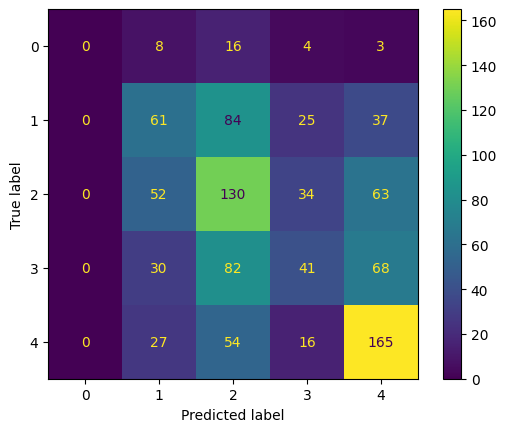

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_v4)
disp = ConfusionMatrixDisplay(cm)
disp.plot()


# Save my predictions

In [72]:
result = pd.DataFrame(data={'base':y_pred_b,
                            'step1':y_pred_1,
                            'step2':y_pred_2,
                            'step3':y_pred_3,
                            'step4':y_pred_4,
                            'best rate':y_pred_4})

result.to_csv("/content/drive/MyDrive/Machine_Learning_Algorithms/Project/save/result.csv")